In [7]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_reshaped = x_train.reshape(-1, 28*28).astype(np.float32).T

digit_indices = [np.flatnonzero(y_train == i) for i in range(10)]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
label_list = np.unique(y_train)

In [20]:
data_matrices = [x_train_reshaped[:, y_train == label] for label in label_list]
data_matrices[0].shape

(784, 5923)

In [21]:
U = [0] * len(label_list)
S = [0] * len(label_list)
Vh = [0] * len(label_list)

# Perform SVD to get the Eigenstuff vector
for index in tqdm(range(len(label_list))):
    u, s, vh = np.linalg.svd(data_matrices[index], full_matrices=False)
    U[index] = u
    S[index] = s
    Vh[index] = vh



100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


In [22]:
U = np.array(U)
S = np.array(S)

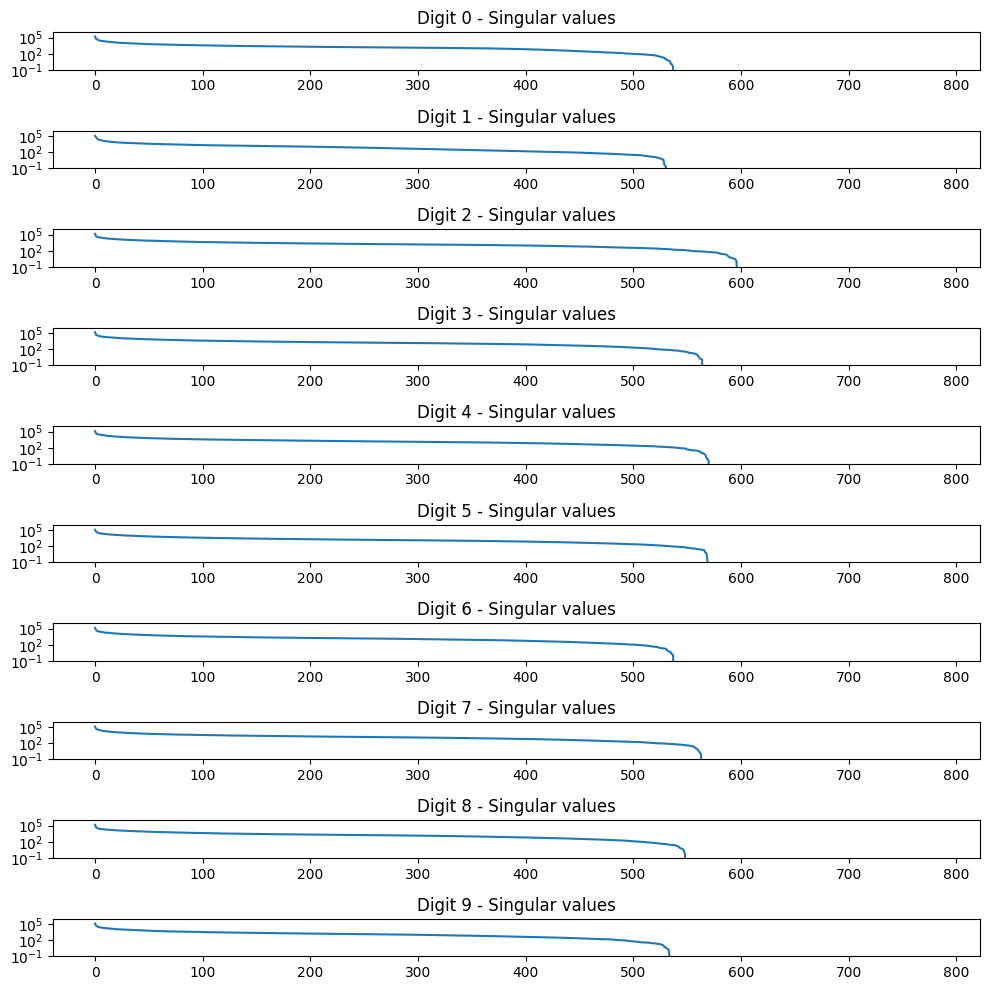

In [29]:
fig, axs = plt.subplots(10, 1, figsize=(10, 10))

for i in range(10):
    axs[i].plot(S[i])
    axs[i].set_yscale('log')
    axs[i].set_title(f"Digit {i} - Singular values")
    axs[i].set_ylim([1e-1, 1e6])

plt.tight_layout()
plt.show()

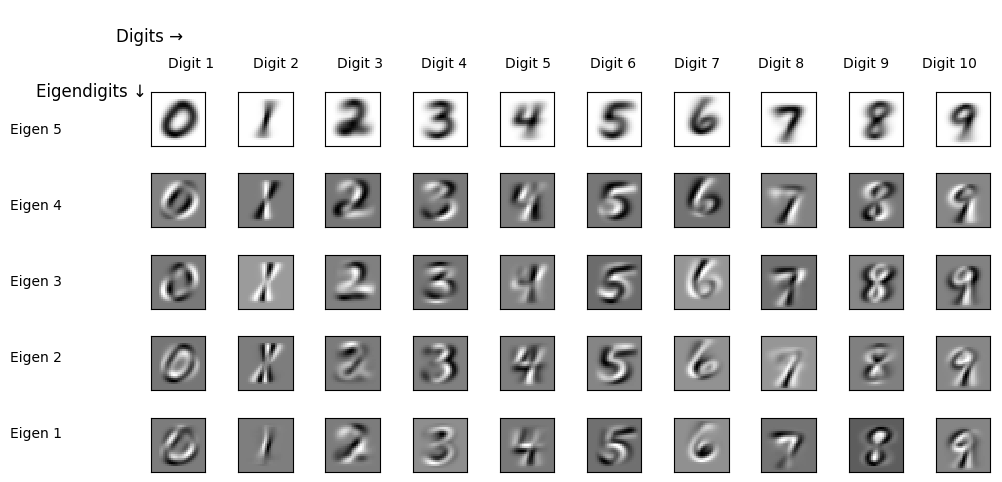

In [30]:
import matplotlib.gridspec as gridspec

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(6, 11, figure=fig)  # 6 rows, 11 columns grid

# Allocate subplots (5x10 for images, extra rows and columns for labels)
image_axes = [[fig.add_subplot(gs[i, j+1]) for j in range(10)] for i in range(1, 6)]
digit_labels = fig.add_subplot(gs[0, 1:], frame_on=False)  # Top labels
eigendigit_labels = fig.add_subplot(gs[1:, 0], frame_on=False)  # Left labels

# Disable ticks and labels on label axes
digit_labels.set_xticks([])
digit_labels.set_yticks([])
eigendigit_labels.set_xticks([])
eigendigit_labels.set_yticks([])

# Plot images and set titles inside the loop
for i in range(10):
    for j in range(5):
        ax = image_axes[j][i]
        ax.imshow(U[i][:, j].reshape(28, 28), cmap='gray', interpolation='none')
        ax.set_xticks([])
        ax.set_yticks([])

# Add text for digits and eigendigits
eigendigit_labels.text(0.5, 1, 'Eigendigits ↓', ha='center', va='center', fontsize=12, rotation=0, transform=eigendigit_labels.transAxes)
digit_labels.text(0, 0.5, 'Digits →', ha='center', va='center', fontsize=12, transform=digit_labels.transAxes)

for i in range(10):
    digit_labels.text(i/10 + 0.05, 0, f'Digit {i+1}', ha='center', va='center', transform=digit_labels.transAxes)
for j in range(5):
    eigendigit_labels.text(0, j/5 + 0.1, f'Eigen {j+1}', ha='right', va='center', transform=eigendigit_labels.transAxes)

fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing
plt.show()


In [54]:
ranks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
I = np.eye(28*28)
predictions = np.zeros((len(y_test), len(ranks)))
for i in range(len(ranks)):
    k = ranks[i]
    projection_matrices = np.einsum('ijk,ilk->ijl', U[:, :, :k], U[:, :, :k])
    residuals = np.tensordot(I - projection_matrices, x_test.reshape(-1, 28*28).T, axes=([1],[0]))
    predictions[:, i] = label_list[np.argmin(np.linalg.norm(residuals, ord=2, axis=1), axis=0)]
    accuracy = np.sum(predictions[:, i] == y_test) / len(y_test)
    print(f'Accuracy with rank {k}: {accuracy}')

Accuracy with rank 1: 0.8184
Accuracy with rank 2: 0.8716
Accuracy with rank 5: 0.9263
Accuracy with rank 10: 0.9485
Accuracy with rank 20: 0.9573
Accuracy with rank 50: 0.9514
Accuracy with rank 100: 0.9286
Accuracy with rank 200: 0.8949
Accuracy with rank 500: 0.5282


In [55]:
ranks = np.arange(1, 501, 10)
I = np.eye(28*28)
predictions = np.zeros((len(y_test), len(ranks)))
accs = []
for i in tqdm(range(len(ranks))):
    k = ranks[i]
    projection_matrices = np.einsum('ijk,ilk->ijl', U[:,:,:k], U[:,:,:k])
    residuals = np.tensordot(I - projection_matrices, x_test.reshape(-1, 28*28).T, axes=([1],[0]))
    predictions[:, i] = label_list[np.argmin(np.linalg.norm(residuals, ord=2, axis=1), axis=0)]
    accuracy = np.sum(predictions[:, i] == y_test) / len(y_test)
    accs.append(accuracy)

100%|██████████| 50/50 [01:23<00:00,  1.66s/it]


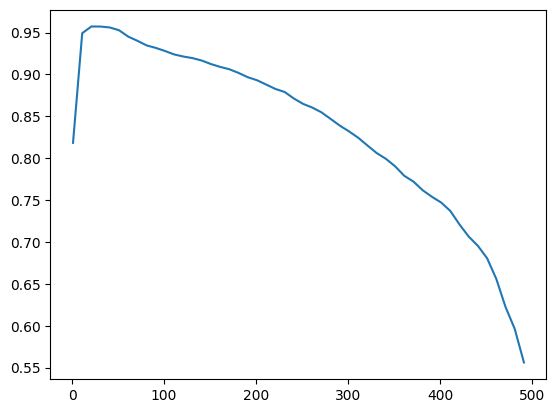

In [58]:
plt.plot(ranks, accs)
plt.show()